In [1]:
%tensorflow_version 2.0
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Input, Flatten,Dense,BatchNormalization,MaxPool2D,Reshape,Conv2DTranspose,LeakyReLU,Dropout
from tensorflow.keras.models import Model
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
tpu_grpc_url = "grpc://" + os.environ["COLAB_TPU_ADDR"]
tpu_cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
tf.config.experimental_connect_to_cluster(tpu_cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(tpu_cluster_resolver)    
strategy = tf.distribute.experimental.TPUStrategy(tpu_cluster_resolver)  

INFO:tensorflow:Initializing the TPU system: 10.103.115.234:8470


INFO:tensorflow:Initializing the TPU system: 10.103.115.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
def make_dataset(X,y):
    
    def preprocess(X,y):
        #return tf.expand_dims((X - 127.5)/128,3),tf.expand_dims(y,1)
        X = tf.cast(X,"float32")
        y = tf.cast(y,"float32")
        return tf.expand_dims((X - 127.5)/128,2),tf.expand_dims(y,0)
    dataset = tf.data.Dataset.from_tensor_slices((X,y))
    dataset = dataset.map(preprocess)
    
    return dataset
train_dataset = make_dataset(X_train,y_train)
train_dataset

<MapDataset shapes: ((28, 28, 1), (1,)), types: (tf.float32, tf.float32)>

In [0]:
def make_generator():
  input_ = Input((100,))
  x = Dense(7*7*256, use_bias=False)(input_)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  x = Reshape((7, 7, 256))(x)

  x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  x = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

  return Model(input_,x)

def make_discriminator():
  input_ = Input((28,28,1))

  x = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input_)
  x = LeakyReLU()(x)
  x = Dropout(0.3)(x)

  x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
  x = LeakyReLU()(x)
  x = Dropout(0.3)(x)

  x = Flatten()(x)
  x = Dense(1)(x)

  return Model(input_,x)


In [26]:
gen = make_generator()
gen.summary()
dis = make_discriminator()
dis.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_15 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_16 (Batc (None, 7, 7, 128)         512 

In [0]:
res = gen.predict(tf.random.normal([1, 100]))

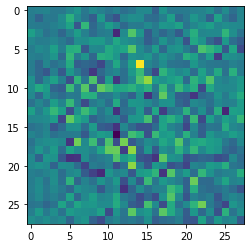

In [30]:
plt.imshow(res[0,:,:,0])

In [0]:
def train(noise_dim=100):
  with strategy.scope():
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
    generator = make_generator()
    discriminator = make_discriminator()

    def discriminator_loss(real_output, fake_output):
      real_loss = cross_entropy(tf.ones_like(real_output), real_output)
      fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
      total_loss = real_loss + fake_loss
      return total_loss

    def generator_loss(fake_output):
      return cross_entropy(tf.ones_like(fake_output), fake_output)

    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)  


    def train_on_batch(X):
      noise = tf.random.normal([X.shape[0], noise_dim])
      with tf.GradientTape() as g_tape,tf.GradientTape() as d_tape:
        gen = generator(noise,training=True)
        real_output = discriminator(X,training=True)
        fake_output = discriminator(gen,training=True)
        g_loss = generator_loss(fake_output)
        g_loss = tf.reduce_sum(g_loss,keepdims=True) / X.shape[0]
        d_loss = discriminator_loss(real_output,fake_output)
        d_loss = tf.reduce_sum(d_loss,keepdims=True)  / X.shape[0]
      g_gradients = g_tape.gradient(g_loss,generator.trainable_variables)
      d_gradients = d_tape.gradient(d_loss,discriminator.trainable_variables)
      generator_optimizer.apply_gradients(zip(g_gradients,generator.trainable_variables)) 
      discriminator_optimizer.apply_gradients(zip(d_gradients,discriminator.trainable_variables))
      return g_loss,d_loss

    @tf.function
    def distributed_train_on_batch(X):
      losses = strategy.experimental_run_v2(train_on_batch, args=(X,))
      return [strategy.reduce(tf.distribute.ReduceOp.SUM, loss, axis=None) for loss in losses]


    train_dataset = make_dataset(X_train,y_train)
    train_dataset = train_dataset.shuffle(buffer_size=1000,reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(2048)
    
    for i in range(120):
      train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset.take(25))
      with tqdm.tqdm(train_dist_dataset) as pbar:
        for step, (X,_) in enumerate(pbar):
          g_loss,d_loss = distributed_train_on_batch(X)
          pbar.set_description(f"{i} epoch, step: {step}")
          pbar.set_postfix({
              "g_loss":g_loss.numpy(),
              "d_loss":d_loss.numpy()
          })

      if i % 5==0:
        noise = tf.random.normal([1, 100])
        gen = generator(noise,training=False)
        plt.imshow(gen[0,:,:,0])
        plt.show()

  


0 epoch, step: 24: : 25it [00:09,  5.39it/s, g_loss=[4.0887766], d_loss=[8.438573]]


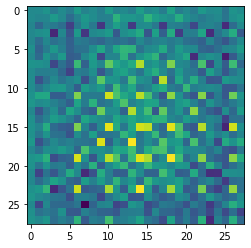

1 epoch, step: 24: : 25it [00:02, 11.48it/s, g_loss=[6.530446], d_loss=[7.0374947]]
2 epoch, step: 24: : 25it [00:02, 11.73it/s, g_loss=[5.378515], d_loss=[8.023819]]
3 epoch, step: 24: : 25it [00:02, 12.67it/s, g_loss=[6.829257], d_loss=[7.8850727]]
4 epoch, step: 24: : 25it [00:02, 12.02it/s, g_loss=[5.608306], d_loss=[8.224026]]
5 epoch, step: 24: : 25it [00:02, 10.99it/s, g_loss=[9.154142], d_loss=[6.1062922]]


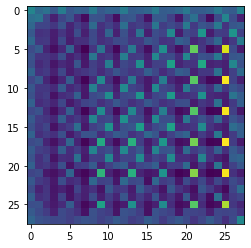

6 epoch, step: 24: : 25it [00:02, 11.80it/s, g_loss=[6.187089], d_loss=[9.92136]]
7 epoch, step: 24: : 25it [00:02, 11.71it/s, g_loss=[7.804647], d_loss=[6.8038306]]
8 epoch, step: 24: : 25it [00:02, 11.28it/s, g_loss=[6.4160786], d_loss=[9.660661]]
9 epoch, step: 24: : 25it [00:02, 12.01it/s, g_loss=[4.7018943], d_loss=[12.908592]]
10 epoch, step: 24: : 25it [00:02, 12.02it/s, g_loss=[6.1353827], d_loss=[10.623481]]


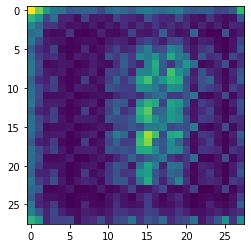

11 epoch, step: 24: : 25it [00:02, 11.69it/s, g_loss=[5.656599], d_loss=[11.09662]]
12 epoch, step: 24: : 25it [00:02, 11.97it/s, g_loss=[6.0690475], d_loss=[9.961733]]
13 epoch, step: 24: : 25it [00:02, 12.27it/s, g_loss=[5.4241495], d_loss=[11.614553]]
14 epoch, step: 24: : 25it [00:02, 12.01it/s, g_loss=[6.8743887], d_loss=[9.556203]]
15 epoch, step: 24: : 25it [00:02, 12.30it/s, g_loss=[7.764685], d_loss=[8.06923]]


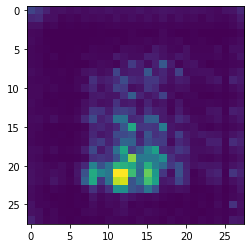

16 epoch, step: 24: : 25it [00:02, 10.24it/s, g_loss=[4.385415], d_loss=[13.150582]]
17 epoch, step: 24: : 25it [00:02, 11.99it/s, g_loss=[8.128906], d_loss=[7.2912846]]
18 epoch, step: 24: : 25it [00:02, 11.92it/s, g_loss=[5.572168], d_loss=[12.535992]]
19 epoch, step: 24: : 25it [00:02, 11.70it/s, g_loss=[8.317314], d_loss=[7.69363]]
20 epoch, step: 24: : 25it [00:02, 11.61it/s, g_loss=[10.144182], d_loss=[5.917403]]


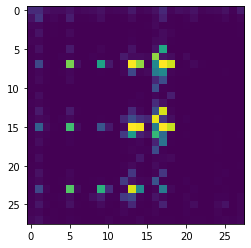

21 epoch, step: 24: : 25it [00:02,  9.85it/s, g_loss=[5.1148925], d_loss=[11.806994]]
22 epoch, step: 24: : 25it [00:02, 11.35it/s, g_loss=[6.9429135], d_loss=[9.016132]]
23 epoch, step: 24: : 25it [00:02, 12.29it/s, g_loss=[8.051084], d_loss=[8.857828]]
24 epoch, step: 24: : 25it [00:02, 12.12it/s, g_loss=[6.840948], d_loss=[10.934674]]
25 epoch, step: 24: : 25it [00:02, 11.29it/s, g_loss=[6.2561083], d_loss=[10.62377]]


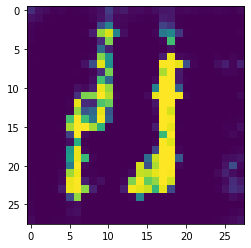

26 epoch, step: 24: : 25it [00:02, 12.06it/s, g_loss=[7.6602087], d_loss=[7.946711]]
27 epoch, step: 24: : 25it [00:02, 11.91it/s, g_loss=[6.2801204], d_loss=[10.473391]]
28 epoch, step: 24: : 25it [00:02, 11.90it/s, g_loss=[5.4740925], d_loss=[12.648512]]
29 epoch, step: 24: : 25it [00:02, 12.00it/s, g_loss=[5.352642], d_loss=[12.436212]]
30 epoch, step: 24: : 25it [00:02, 12.17it/s, g_loss=[6.6417627], d_loss=[10.043695]]


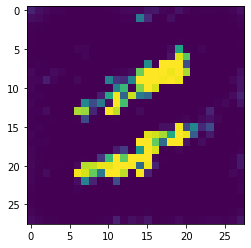

31 epoch, step: 24: : 25it [00:02, 11.73it/s, g_loss=[6.6961164], d_loss=[9.37383]]
32 epoch, step: 24: : 25it [00:02, 11.73it/s, g_loss=[6.3234987], d_loss=[9.71116]]
33 epoch, step: 24: : 25it [00:02, 11.88it/s, g_loss=[5.8248415], d_loss=[10.746196]]
34 epoch, step: 24: : 25it [00:02, 12.03it/s, g_loss=[5.6327705], d_loss=[12.010859]]
35 epoch, step: 24: : 25it [00:02, 11.92it/s, g_loss=[6.832183], d_loss=[9.468113]]


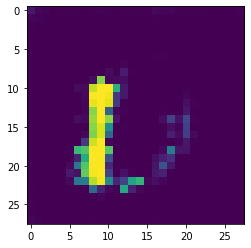

36 epoch, step: 24: : 25it [00:02, 11.47it/s, g_loss=[6.2197347], d_loss=[10.212047]]
37 epoch, step: 24: : 25it [00:02, 11.75it/s, g_loss=[5.6160994], d_loss=[11.00873]]
38 epoch, step: 24: : 25it [00:02, 11.76it/s, g_loss=[5.947726], d_loss=[11.327812]]
39 epoch, step: 24: : 25it [00:02, 11.58it/s, g_loss=[5.9005113], d_loss=[11.173339]]
40 epoch, step: 24: : 25it [00:02, 11.95it/s, g_loss=[5.841349], d_loss=[10.841311]]


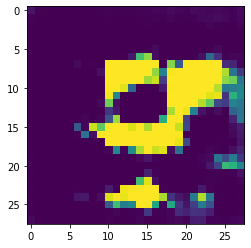

41 epoch, step: 24: : 25it [00:02, 11.06it/s, g_loss=[7.281301], d_loss=[8.613471]]
42 epoch, step: 24: : 25it [00:02, 11.25it/s, g_loss=[5.647462], d_loss=[11.871031]]
43 epoch, step: 24: : 25it [00:02, 11.35it/s, g_loss=[4.6740355], d_loss=[13.826252]]
44 epoch, step: 24: : 25it [00:02, 11.67it/s, g_loss=[5.753978], d_loss=[11.762077]]
45 epoch, step: 24: : 25it [00:02, 11.44it/s, g_loss=[6.5211697], d_loss=[10.186924]]


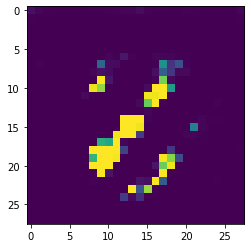

46 epoch, step: 24: : 25it [00:02, 12.00it/s, g_loss=[7.4839363], d_loss=[8.882679]]
47 epoch, step: 24: : 25it [00:02, 11.43it/s, g_loss=[6.006963], d_loss=[11.2505045]]
48 epoch, step: 24: : 25it [00:02, 11.87it/s, g_loss=[6.4481206], d_loss=[9.293652]]
49 epoch, step: 24: : 25it [00:02, 11.80it/s, g_loss=[7.9914885], d_loss=[8.48921]]
50 epoch, step: 24: : 25it [00:02, 11.73it/s, g_loss=[5.071776], d_loss=[13.697998]]


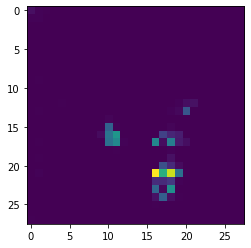

51 epoch, step: 24: : 25it [00:02, 11.35it/s, g_loss=[6.3607883], d_loss=[10.474089]]
52 epoch, step: 24: : 25it [00:02, 11.70it/s, g_loss=[7.15124], d_loss=[9.456035]]
53 epoch, step: 24: : 25it [00:02, 11.74it/s, g_loss=[6.1984406], d_loss=[10.382478]]
54 epoch, step: 24: : 25it [00:02, 11.21it/s, g_loss=[6.703433], d_loss=[9.756941]]
55 epoch, step: 24: : 25it [00:02, 11.81it/s, g_loss=[5.9544077], d_loss=[11.425183]]


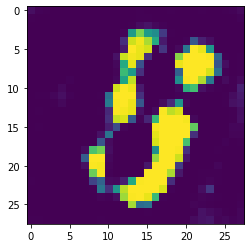

56 epoch, step: 24: : 25it [00:02, 12.31it/s, g_loss=[5.6165285], d_loss=[12.27439]]
57 epoch, step: 24: : 25it [00:02, 11.61it/s, g_loss=[6.638376], d_loss=[10.15538]]
58 epoch, step: 24: : 25it [00:02, 12.15it/s, g_loss=[6.634861], d_loss=[9.948158]]
59 epoch, step: 24: : 25it [00:02, 12.20it/s, g_loss=[5.6947136], d_loss=[11.522581]]
60 epoch, step: 24: : 25it [00:02, 11.75it/s, g_loss=[5.6327357], d_loss=[11.204865]]


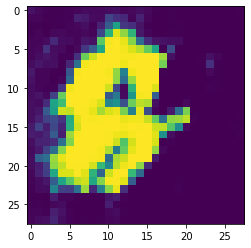

61 epoch, step: 24: : 25it [00:02, 11.89it/s, g_loss=[6.646161], d_loss=[9.703091]]
62 epoch, step: 24: : 25it [00:02, 11.71it/s, g_loss=[6.2025514], d_loss=[10.9709835]]
63 epoch, step: 24: : 25it [00:02, 10.91it/s, g_loss=[6.549291], d_loss=[10.280204]]
64 epoch, step: 24: : 25it [00:02, 11.52it/s, g_loss=[6.8143725], d_loss=[9.898235]]
65 epoch, step: 24: : 25it [00:02, 11.49it/s, g_loss=[5.238977], d_loss=[12.002289]]


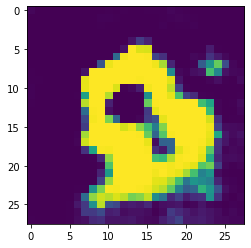

66 epoch, step: 24: : 25it [00:02, 12.27it/s, g_loss=[7.237231], d_loss=[9.024414]]
67 epoch, step: 24: : 25it [00:02, 10.92it/s, g_loss=[5.641024], d_loss=[12.789599]]
68 epoch, step: 24: : 25it [00:02, 11.58it/s, g_loss=[6.7462587], d_loss=[10.286928]]
69 epoch, step: 24: : 25it [00:02, 11.75it/s, g_loss=[7.803744], d_loss=[8.510338]]
70 epoch, step: 24: : 25it [00:02, 11.21it/s, g_loss=[5.337681], d_loss=[11.776102]]


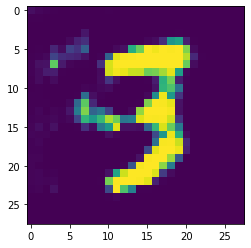

71 epoch, step: 24: : 25it [00:02, 11.41it/s, g_loss=[7.248115], d_loss=[8.6836195]]
72 epoch, step: 24: : 25it [00:02, 12.14it/s, g_loss=[6.6897864], d_loss=[10.540404]]
73 epoch, step: 24: : 25it [00:02, 11.97it/s, g_loss=[6.6001587], d_loss=[10.408157]]
74 epoch, step: 24: : 25it [00:02, 11.56it/s, g_loss=[7.099362], d_loss=[9.641409]]
75 epoch, step: 24: : 25it [00:02, 11.69it/s, g_loss=[6.5229774], d_loss=[10.4509735]]


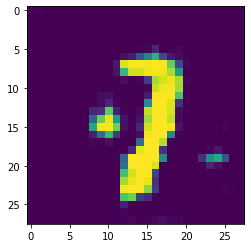

76 epoch, step: 24: : 25it [00:02,  9.86it/s, g_loss=[6.8298244], d_loss=[9.986792]]
77 epoch, step: 24: : 25it [00:02, 11.95it/s, g_loss=[5.428687], d_loss=[12.4512615]]
78 epoch, step: 24: : 25it [00:02, 10.64it/s, g_loss=[6.026313], d_loss=[11.970714]]
79 epoch, step: 24: : 25it [00:02, 12.21it/s, g_loss=[8.364468], d_loss=[8.07934]]
80 epoch, step: 24: : 25it [00:02, 11.00it/s, g_loss=[8.56107], d_loss=[8.34806]]


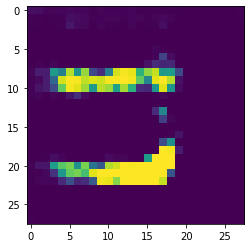

81 epoch, step: 24: : 25it [00:02, 11.05it/s, g_loss=[5.994237], d_loss=[10.846926]]
82 epoch, step: 24: : 25it [00:02, 12.08it/s, g_loss=[8.296133], d_loss=[8.075718]]
83 epoch, step: 24: : 25it [00:02, 11.99it/s, g_loss=[6.8566346], d_loss=[10.669759]]
84 epoch, step: 24: : 25it [00:02, 10.02it/s, g_loss=[7.116052], d_loss=[9.415896]]
85 epoch, step: 24: : 25it [00:02,  9.99it/s, g_loss=[7.15819], d_loss=[9.27095]]


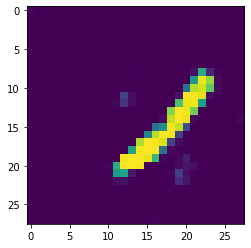

86 epoch, step: 24: : 25it [00:02, 12.17it/s, g_loss=[7.432939], d_loss=[8.892456]]
87 epoch, step: 24: : 25it [00:02, 10.78it/s, g_loss=[7.9581995], d_loss=[8.878706]]
88 epoch, step: 24: : 25it [00:02, 11.93it/s, g_loss=[4.7348213], d_loss=[13.326545]]
89 epoch, step: 24: : 25it [00:02, 12.04it/s, g_loss=[7.908665], d_loss=[8.453768]]
90 epoch, step: 24: : 25it [00:02, 11.89it/s, g_loss=[6.968732], d_loss=[10.647112]]


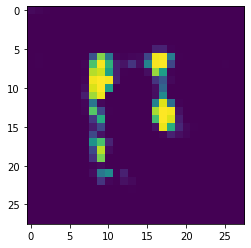

91 epoch, step: 24: : 25it [00:02, 12.00it/s, g_loss=[8.637276], d_loss=[8.024575]]
92 epoch, step: 24: : 25it [00:02, 12.18it/s, g_loss=[7.746075], d_loss=[9.406708]]
93 epoch, step: 24: : 25it [00:02, 12.17it/s, g_loss=[5.8723955], d_loss=[11.4057]]
94 epoch, step: 24: : 25it [00:02, 11.87it/s, g_loss=[8.349178], d_loss=[8.270232]]
95 epoch, step: 24: : 25it [00:02, 12.18it/s, g_loss=[8.020337], d_loss=[9.552109]]


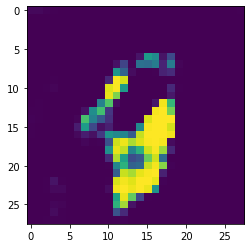

96 epoch, step: 24: : 25it [00:02, 12.02it/s, g_loss=[6.761087], d_loss=[11.862923]]
97 epoch, step: 24: : 25it [00:02,  9.18it/s, g_loss=[5.822874], d_loss=[11.806613]]
98 epoch, step: 24: : 25it [00:02, 11.55it/s, g_loss=[7.2098517], d_loss=[9.002464]]
99 epoch, step: 24: : 25it [00:02, 11.79it/s, g_loss=[8.180539], d_loss=[8.167284]]
100 epoch, step: 24: : 25it [00:02, 12.05it/s, g_loss=[7.141444], d_loss=[9.667201]]


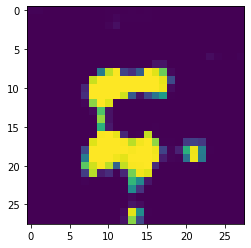

101 epoch, step: 24: : 25it [00:02, 12.37it/s, g_loss=[6.8724995], d_loss=[10.383929]]
102 epoch, step: 24: : 25it [00:02, 11.58it/s, g_loss=[6.8360634], d_loss=[10.212403]]
103 epoch, step: 24: : 25it [00:02, 11.16it/s, g_loss=[6.9972057], d_loss=[9.387496]]
104 epoch, step: 24: : 25it [00:02, 11.94it/s, g_loss=[7.5712023], d_loss=[9.017332]]
105 epoch, step: 24: : 25it [00:02, 11.17it/s, g_loss=[6.667668], d_loss=[10.929008]]


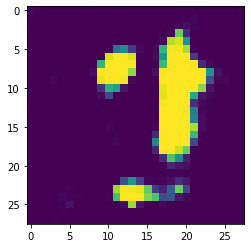

106 epoch, step: 24: : 25it [00:02, 12.35it/s, g_loss=[6.525295], d_loss=[10.929231]]
107 epoch, step: 24: : 25it [00:02, 12.36it/s, g_loss=[7.6370726], d_loss=[8.534961]]
108 epoch, step: 24: : 25it [00:02, 11.86it/s, g_loss=[7.5762053], d_loss=[8.782919]]
109 epoch, step: 24: : 25it [00:02, 10.98it/s, g_loss=[6.122772], d_loss=[11.595771]]
110 epoch, step: 24: : 25it [00:02, 11.50it/s, g_loss=[6.6853333], d_loss=[11.089676]]


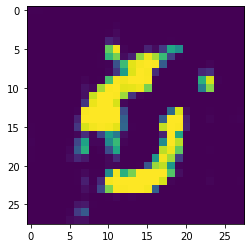

111 epoch, step: 24: : 25it [00:02, 12.15it/s, g_loss=[8.500721], d_loss=[8.105754]]
112 epoch, step: 24: : 25it [00:02, 11.70it/s, g_loss=[8.020984], d_loss=[9.305985]]
113 epoch, step: 24: : 25it [00:02, 11.25it/s, g_loss=[7.5859528], d_loss=[9.414709]]
114 epoch, step: 24: : 25it [00:02, 10.75it/s, g_loss=[6.1292], d_loss=[12.116015]]
115 epoch, step: 24: : 25it [00:02, 12.45it/s, g_loss=[7.0488725], d_loss=[9.857134]]


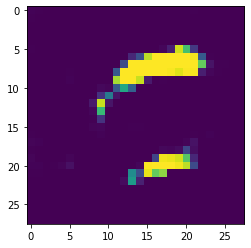

116 epoch, step: 24: : 25it [00:02, 12.19it/s, g_loss=[9.453232], d_loss=[6.6765013]]
117 epoch, step: 24: : 25it [00:02, 10.79it/s, g_loss=[9.17962], d_loss=[7.297981]]
118 epoch, step: 24: : 25it [00:02, 11.20it/s, g_loss=[6.6004415], d_loss=[11.92892]]
119 epoch, step: 24: : 25it [00:02, 12.31it/s, g_loss=[5.4842014], d_loss=[12.931931]]


In [11]:
train()